# Random Forest - Selección de características mediante algoritmo genético
## Grado en Ingeniería Informática. Universidad de Burgos
**Autor:** Alicia Olivares Gil

In [1]:
%matplotlib inline 
#para dibujar en el propio notebook
import pandas as pd # se importa pandas como pd
import numpy as np  #numpy como np
import matplotlib.pyplot as plt #matplotlib.pyplot como plot
import pickle as pk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics as mtr
from deap import base, creator, tools, algorithms
import random
import time 

## Cargar características: 

In [2]:
with open('selection_diacrisis1.pdd','rb') as f: 
    features_diacrisis1 = pk.load(f) 
with open('selection_diacrisis2.pdd','rb') as f: 
    features_diacrisis2 = pk.load(f)
    
features_diacrisis1 = features_diacrisis1.drop(['P1__sample_entropy','P2__sample_entropy','P3__sample_entropy','P4__sample_entropy','P5__sample_entropy','P6__sample_entropy'], axis=1)
features_diacrisis2 = features_diacrisis2.drop(['P1__sample_entropy','P2__sample_entropy','P3__sample_entropy','P4__sample_entropy','P5__sample_entropy','P6__sample_entropy'], axis=1)

print('Filas característcias crisis 1: ',features_diacrisis1.shape[0])
print('Filas característcias crisis 2: ',features_diacrisis2.shape[0])
print('Número de características:',int((features_diacrisis1.shape[1]-1)/6))
# se divide entre 6 porque se incluye la misma característica por cada uno de los 6 tubos de presión 

Filas característcias crisis 1:  121889
Filas característcias crisis 2:  123435
Número de características: 123


In [3]:
features_names = []
for c in features_diacrisis1.columns: 
    if c[2:] not in features_names and c!='target': 
        features_names.append(c[2:])
print('Número de características:',len(features_names))

Número de características: 123


## Configurar algoritmo genético: 
#### Configuración de los individuos: 

In [4]:
def configuraPoblacion(toolbox):

    #maximizar 
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    n_features = len(features_names)
    
    #Los genes son de tipo entero. Cada entero representa una característica.
    toolbox.register("attribute", random.sample, range(n_features-1), 10) 
    #El individuo se crea como una lista (o repeticion) de "attribute", definido justo antes. 
    #Tendrá una longitud de 10 atributos
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attribute)
    
    #La población se crea como una lista de "individual", definido justo antes
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#### Función de evaluación: 

Devuelve el roc obtenido mediante la combinación de características extraídas del genotipo del individuo. 

In [5]:
def evalROC(individual):
    global metric

    auc =0
    
    individual = list(set(individual))

    rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    y1 = features_diacrisis1['target']
    y2 = features_diacrisis2['target']
    
    X1 = pd.DataFrame()
    X2 = pd.DataFrame()

    for i in range(len(individual)):
        for j in range(1,7):
            nombre = 'P'+str(j)+features_names[individual[i]]
            X1[nombre] = features_diacrisis1[nombre]
            X2[nombre] = features_diacrisis2[nombre]
    
    rfc.fit(X1, y1)
    y_pred = rfc.predict_proba(X2)
    y_score = [i[0] for i in y_pred]
    auc1 = metric(y2,y_score)

    rfc.fit(X2, y2)
    y_pred = rfc.predict_proba(X1)
    y_score = [i[0] for i in y_pred]
    auc2 = metric(y1,y_score)

    auc= (auc1+auc2)/2
    end = time.time()

    return (auc,)

#### Configuración del algoritmo: 

Define: 
    - Procedimientos y parámetros de cruce, mutación y selección. 
    - La función de evaluación a emplear 

In [6]:
def configuracionAlgoritmo(toolbox): 
    n_features = len(features_names)
    
    # Se seleccionan procedimiento standard para cruce, mutacion y seleccion
    toolbox.register("mate", tools.cxUniform, indpb=0.5)
    toolbox.register("mutate", tools.mutUniformInt,low=0, up=(n_features-1), indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    # Se define cómo se evaluará cada individuo
    # En este caso, se hará uso de la función de evaluación que se ha definido en la celda anterior 
    toolbox.register("evaluate", evalROC)

#### Definir parámetros principales del algoritmo y función de evoluación : 

In [7]:
probCruce = 0.6
probMutacion = 0.1
nGeneraciones = 50
tamPoblacion = 50

In [8]:
def realizaEvolucion(toolbox, stats):
    
    global probCruce
    global probMutacion
    global nGeneraciones
    global tamPoblacion

    # Se configura cómo se define cada individuo.
    configuraPoblacion(toolbox)

    configuracionAlgoritmo(toolbox)

    # Se inicializa la poblacion con los individuos especificados en Main.py
    population = toolbox.population(n=tamPoblacion)
    hof=tools.HallOfFame(1)
    # Se llama al algoritmo que permite la evolucion de las soluciones con los parametros especificados en Main.py
    population, logbook = algorithms.eaSimple(population, toolbox, cxpb=probCruce, mutpb=probMutacion, ngen=nGeneraciones, verbose=False, stats=stats,halloffame=hof)     
    
    return logbook,hof[0]

#### Función auxiliar para mostrar la evolución del algoritmo: 

In [4]:
def mostrarGrafica(logbook): 
    #imprimir grafica 
    ejex = logbook.select("gen")
    maximo = logbook.select("max")
    minimo = logbook.select("min")
    media = logbook.select("avg")
    desviacion = logbook.select("std")
    
    plt.figure(figsize=(8,6),dpi=80)
    plt.subplot(221)
    plt.plot(ejex,maximo, color="green")
    plt.title("max/gen")
    plt.xlabel("generacion")
    plt.ylabel("maxima precisión")
    plt.subplot(222)
    plt.plot(ejex,minimo, color="red")
    plt.title("min/gen")
    plt.xlabel("generacion")
    plt.ylabel("mínima precisión")
    plt.subplot(223)
    plt.plot(ejex, media, color="blue")
    plt.title("med/gen")
    plt.xlabel("generacion")
    plt.ylabel("precisión media ")
    plt.subplot(224)
    plt.plot(ejex, desviacion, color="orange")
    plt.title("desviacion/gen")
    plt.xlabel("generacion")
    plt.ylabel("desviación")
    plt.tight_layout()

#### Realizar evolución: 

1. Para la métrica average_precision_score: 

In [10]:
metric = mtr.average_precision_score

In [11]:
#generar estadisticas
toolbox = base.Toolbox()
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#realizar evolución 
logbook,best=realizaEvolucion(toolbox,stats)

with open('logbook_prc.pkl','wb') as f:
    pk.dump(logbook,f)
with open('best_prc.pkl', 'wb') as f: 
    pk.dump(best,f)

In [5]:
logbook = pk.load(open('logbook_prc.pkl','rb'))
best = pk.load(open('best_prc.pkl','rb'))

gen	nevals	avg      	std      	min       	max      
0  	50    	0.0222229	0.0128279	0.00834264	0.0749395
1  	36    	0.0297384	0.0139128	0.0117742 	0.0749395
2  	31    	0.0327413	0.012117 	0.0125939 	0.0656244
3  	31    	0.039292 	0.0165246	0.015382  	0.0837657
4  	37    	0.0458459	0.024664 	0.0154136 	0.130444 
5  	32    	0.0525772	0.0278822	0.0145594 	0.130444 
6  	33    	0.057463 	0.0304928	0.0194374 	0.130444 
7  	32    	0.0667933	0.0317406	0.0167    	0.13922  
8  	28    	0.0746982	0.0347768	0.0173302 	0.147477 
9  	29    	0.0783227	0.036847 	0.0174445 	0.147477 
10 	38    	0.0841681	0.0383199	0.0155466 	0.147477 
11 	32    	0.0875878	0.0390071	0.0188553 	0.147477 
12 	34    	0.0933048	0.0389161	0.0198736 	0.148294 
13 	36    	0.0948529	0.0413807	0.0161515 	0.148294 
14 	30    	0.10251  	0.039166 	0.0164256 	0.15845  
15 	33    	0.102253 	0.0384533	0.0237704 	0.163443 
16 	39    	0.0980783	0.0418835	0.0133456 	0.163443 
17 	34    	0.101811 	0.0421254	0.0204799 	0.163443 
18 	31    	0

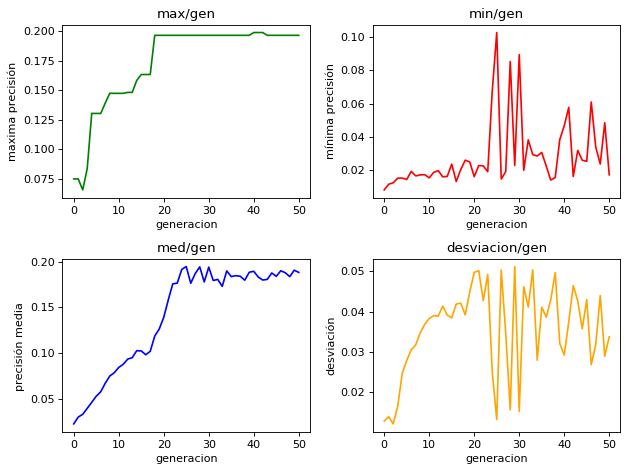

In [6]:
#imprimir estadisticas
print(logbook)

#imprimir Grafica
mostrarGrafica(logbook)

print("El mejor individuo encontrado es: ")
print(best)

### Generar dataframes con las características del mejor individuo: 

In [11]:
diacrisis1 = pk.load(open('diacrisis1.pdd','rb'))
diacrisis2 = pk.load(open('diacrisis2.pdd','rb'))
diacrisis1 = diacrisis1[90:].reset_index(drop=True)
diacrisis2 = diacrisis2[90:].reset_index(drop=True)

seleccion_genetico_diacrisis1 = pd.DataFrame()
seleccion_genetico_diacrisis2 = pd.DataFrame()
for i in range(len(best)):
    for j in range(1,7):
        nombre = 'P'+str(j)+features_names[best[i]]
        print(nombre)
        seleccion_genetico_diacrisis1[nombre] = features_diacrisis1[nombre]
        seleccion_genetico_diacrisis2[nombre] = features_diacrisis2[nombre]

seleccion_genetico_diacrisis2 = seleccion_genetico_diacrisis2.reset_index(drop=True)
features_diacrisis2 = features_diacrisis2.reset_index(drop=True)
        
seleccion_genetico_diacrisis1 = pd.concat([diacrisis1['DateTime'], seleccion_genetico_diacrisis1, features_diacrisis1['target']],axis=1)
seleccion_genetico_diacrisis2 = pd.concat([diacrisis2['DateTime'], seleccion_genetico_diacrisis2, features_diacrisis2['target']],axis=1)

with open('seleccion_genetico_diacrisis1_prc.pdd','wb') as f:
    pk.dump(seleccion_genetico_diacrisis1,f)
with open('seleccion_genetico_diacrisis2_prc.pdd', 'wb') as f: 
    pk.dump(seleccion_genetico_diacrisis2,f)

P1__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"
P2__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"
P3__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"
P4__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"
P5__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"
P6__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"
P1__symmetry_looking__r_0.6000000000000001
P2__symmetry_looking__r_0.6000000000000001
P3__symmetry_looking__r_0.6000000000000001
P4__symmetry_looking__r_0.6000000000000001
P5__symmetry_looking__r_0.6000000000000001
P6__symmetry_looking__r_0.6000000000000001
P1__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2
P2__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2
P3__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2
P4__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2
P5__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2
P6__change_quantiles__f_agg_"var"__is